In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('DatesCorrected.csv',
                index_col=0, parse_dates=True)
df_model_preparation = df[df.index.year <=2014]
df_model_testing = df[df.index.year>=2015]
df_model_preparation.head()

,onstreaminject_HRS,BORE_WI_VOL,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P in percentage,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
2007-01-09,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-10,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-11,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-12,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-13,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
df_original = df_model_preparation.copy()
df = df_original.loc[:,['BORE_OIL_VOL']]
df

,BORE_OIL_VOL
2007-01-09,0.0
2007-01-10,0.0
2007-01-11,0.0
2007-01-12,0.0
2007-01-13,0.0
...,...
2014-12-27,426.0
2014-12-28,423.0
2014-12-29,425.0
2014-12-30,419.0


<AxesSubplot:>

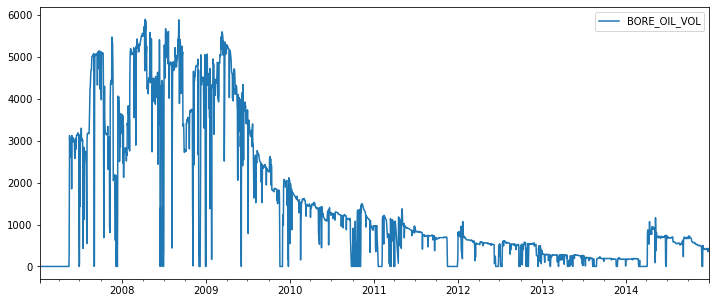

In [3]:
df.plot(figsize=(12,5))

In [4]:
df.shift(1)

,BORE_OIL_VOL
2007-01-09,NaN
2007-01-10,0.0
2007-01-11,0.0
2007-01-12,0.0
2007-01-13,0.0
...,...
2014-12-27,427.0
2014-12-28,426.0
2014-12-29,423.0
2014-12-30,425.0


In [5]:
window= 60
def TS_to_Xy(df,n_lags=3, window=window):
    
    shifted_ys = []
    
    for i in range(1,n_lags+1):
        df[f'y_{i}'] = 0
        df[f'y_{i}'] = df.shift(i+window)
    
    
    
    return df
df_Xy = TS_to_Xy(df.rolling('30D').mean(),1)
df_Xy.head()

,BORE_OIL_VOL,y_1
2007-01-09,0.0,NaN
2007-01-10,0.0,NaN
2007-01-11,0.0,NaN
2007-01-12,0.0,NaN
2007-01-13,0.0,NaN


<AxesSubplot:>

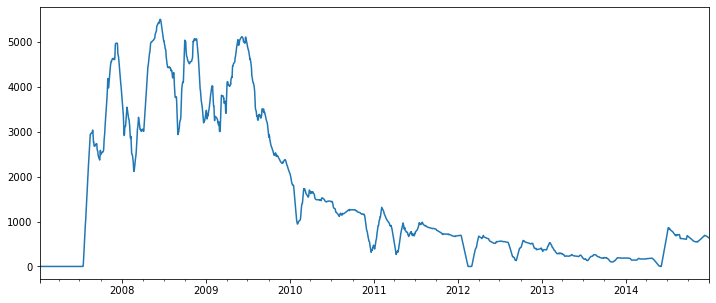

In [6]:
df_Xy = df_Xy.fillna(method='bfill')
df_Xy['y_1'].plot(figsize=(12,5))

Text(0.5, 1.0, 'RMSE = 450.62055219051143')

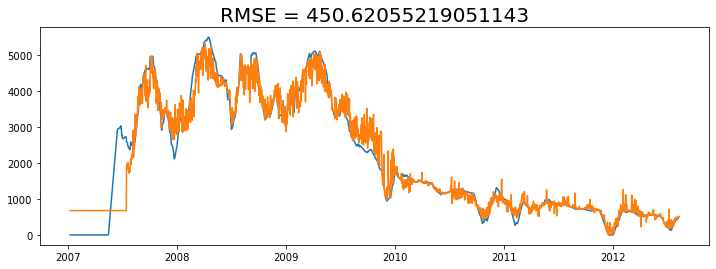

In [7]:
from sklearn.model_selection import train_test_split
X = df_Xy[[col for col in df_Xy.columns if col.startswith('y')]]
y = df_Xy['BORE_OIL_VOL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
RandomForestRegressor()
yp_train = rf.predict(X_train)
plt.figure(figsize=(12,4))

plt.plot(X_train.index, y_train)
plt.plot(X_train.index, yp_train)

plt.title(f'RMSE = {np.sqrt(mean_squared_error(y_train,yp_train))}', size=20)

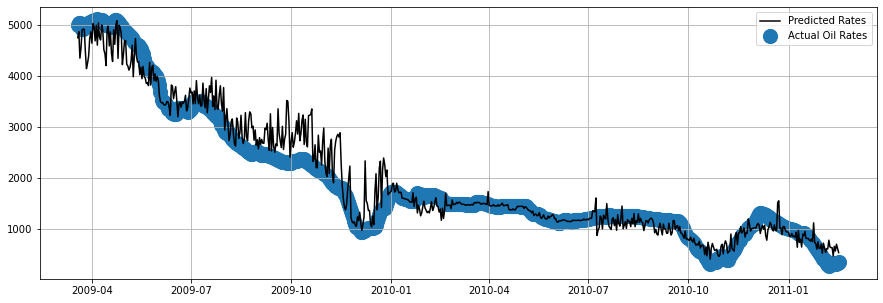

In [8]:
ti = 800;  tf = 1500 

plt.figure(figsize=(15,5))

plt.scatter(df_Xy.index[ti:tf] , df_Xy['BORE_OIL_VOL'][ti:tf], marker='o', label='Actual Oil Rates', s=200)
plt.plot(df_Xy.index[ti:tf] , rf.predict(df_Xy[['BORE_OIL_VOL']][ti-window:tf-window]),color='k', label='Predicted Rates')


# plt.plot(df_Xy.index[ti:tf] , df_Xy['BORE_OIL_VOL'][ti:tf], marker='x', label='Actual Oil Rates')

plt.grid()
plt.legend()

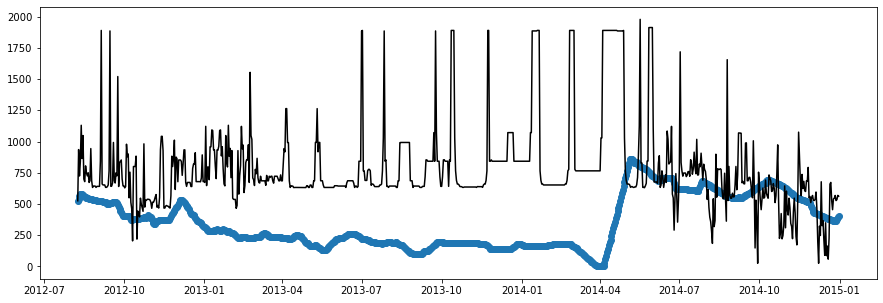

In [9]:
yp_test = rf.predict(X_test)
plt.figure(figsize=(15,5))
plt.scatter(X_test.index, y_test)
plt.plot(X_test.index, yp_test, color='k')

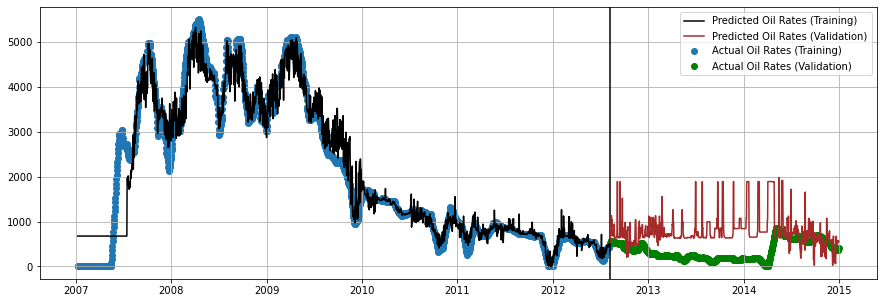

In [10]:
plt.figure(figsize=(15,5))






plt.scatter(X_train.index, y_train, label='Actual Oil Rates (Training)')
plt.plot(X_train.index, yp_train, color='k', label='Predicted Oil Rates (Training)')



plt.axvline(X_test.index[0], color='k')

plt.scatter(X_test.index, y_test, color='green', label='Actual Oil Rates (Validation)')
plt.plot(X_test.index, yp_test, color='brown', label='Predicted Oil Rates (Validation)')




plt.grid()
plt.legend()

In [11]:
X_test

,y_1
2012-08-09,517.833333
2012-08-10,502.288889
2012-08-11,486.366667
2012-08-12,471.266667
2012-08-13,461.233333
...,...
2014-12-27,645.100000
2014-12-28,641.533333
2014-12-29,637.500000
2014-12-30,631.866667


In [12]:
last_input_rates = X_test.iloc[-window:,0:]

next_forecasts = np.array(rf.predict(last_input_rates))
# len(next_forecasts)
df_model_testing.index[:window]

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12',
               '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16',
               '2015-01-17', '2015-01-18', '2015-01-19', '2015-01-20',
               '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24',
               '2015-01-25', '2015-01-26', '2015-01-27', '2015-01-28',
               '2015-01-29', '2015-01-30', '2015-01-31', '2015-02-01',
               '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05',
               '2015-02-06', '2015-02-07', '2015-02-08', '2015-02-09',
               '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13',
               '2015-02-14', '2015-02-15', '2015-02-16', '2015-02-17',
               '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21',
               '2015-02-22', '2015-02-23', '2015-02-24', '2015-02-25',
      

In [13]:
df_model_testing

,onstreaminject_HRS,BORE_WI_VOL,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P in percentage,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
2015-01-01,24.0,4329,24.0,0.0,0.0,29.851,11.949,97.91667,29.851,78.719,0.791,416.0,63439.0,1130.0
2015-01-02,24.0,4302,24.0,0.0,0.0,29.568,12.034,97.91667,29.568,79.787,0.563,386.0,58583.0,1106.0
2015-01-03,24.0,4357,24.0,0.0,0.0,28.611,12.058,100.00000,28.611,80.596,0.533,392.0,59618.0,1143.0
2015-01-04,24.0,4629,24.0,0.0,0.0,26.566,12.131,100.00000,26.566,81.662,0.579,408.0,61965.0,1176.0
2015-01-05,21.5,4174,24.0,0.0,0.0,26.607,12.155,100.00000,26.607,81.569,0.627,405.0,61606.0,1210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-08,0.0,0,0.0,0.0,0.0,0.000,19.959,0.90339,0.000,0.000,0.026,0.0,0.0,0.0
2016-01-09,0.0,0,0.0,0.0,0.0,0.000,19.959,0.90339,0.000,0.000,0.026,0.0,0.0,0.0
2016-01-10,0.0,0,0.0,0.0,0.0,0.000,19.959,0.90339,0.000,0.000,0.026,0.0,0.0,0.0
2016-01-11,0.0,0,0.0,0.0,0.0,0.000,19.959,0.90339,0.000,0.000,0.026,0.0,0.0,0.0


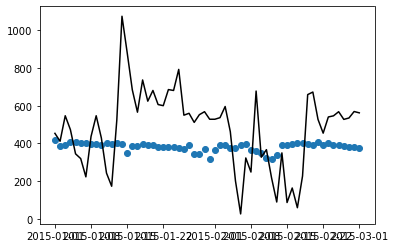

In [14]:
plt.scatter(df_model_testing.index[:window], df_model_testing['BORE_OIL_VOL'][:window], label='Actual Future Rates')
plt.plot(df_model_testing.index[:window], next_forecasts.reshape(window,1), label='Model Forecasted Rates', color='k')

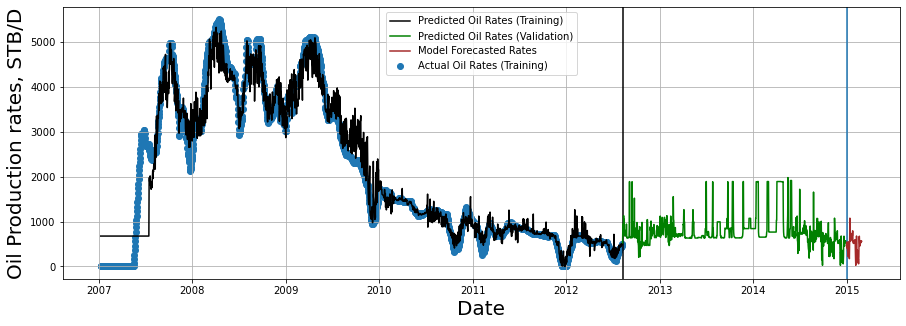

In [15]:
plt.figure(figsize=(15,5))






plt.scatter(X_train.index, y_train, label='Actual Oil Rates (Training)')
plt.plot(X_train.index, yp_train, color='k', label='Predicted Oil Rates (Training)')



plt.axvline(X_test.index[0], color='k')

# plt.scatter(X_test.index, y_test, color='green', label='Actual Oil Rates (Validation)')
plt.plot(X_test.index, yp_test, label='Predicted Oil Rates (Validation)', color='green')

plt.axvline(df_model_testing.index[0])

# plt.scatter(df_model_testing.index[:window], df_model_testing['BORE_OIL_VOL'][:window], label='Actual Future Rates')
plt.plot(df_model_testing.index[:window], next_forecasts, label='Model Forecasted Rates', color='brown')






plt.ylabel('Oil Production rates, STB/D', size=20);
plt.xlabel('Date', size=20)
plt.grid()
plt.legend()